In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
root = "competition_data"

In [3]:
train_cols = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
df_train = pd.read_csv(os.path.join(root, 'train.csv'), usecols=train_cols, parse_dates=['datetime'])

df_train["category_1"] = df_train["county"].astype(str) + "_" + df_train["is_business"].astype(str) + "_" + df_train["product_type"].astype(str) + "_" + df_train["is_consumption"].astype(str)
df_train["log_target"] = np.log(df_train["target"] + 0.001)

In [4]:
all_times = pd.date_range(start=df_train["datetime"].min(), end=df_train["datetime"].max(), freq='H')

In [5]:
all_cat = list(set(df_train["category_1"]))
all_cat.sort()
df_dict = {}
sparse_df_dict = {}
for i, cat in enumerate(all_cat):
    df_dict[cat] = df_train[df_train["category_1"] == cat]
    
    # Fill in missing times with NAN
    df_dict[cat] = df_dict[cat].set_index("datetime").reindex(all_times).reset_index().rename(columns={"index": "datetime"})

    # Count and print the number of target values that are NAN in each category
    print("Category: {}, NAN count: {}".format(cat, df_dict[cat]["target"].isnull().sum()))
    if df_dict[cat]["target"].isnull().sum() > 8:
        sparse_df_dict[cat] = df_dict[cat]



Category: 0_0_1_0, NAN count: 4
Category: 0_0_1_1, NAN count: 4
Category: 0_0_2_0, NAN count: 4
Category: 0_0_2_1, NAN count: 4
Category: 0_0_3_0, NAN count: 4
Category: 0_0_3_1, NAN count: 4
Category: 0_1_0_0, NAN count: 4
Category: 0_1_0_1, NAN count: 4
Category: 0_1_1_0, NAN count: 4
Category: 0_1_1_1, NAN count: 4
Category: 0_1_2_0, NAN count: 724
Category: 0_1_2_1, NAN count: 724
Category: 0_1_3_0, NAN count: 4
Category: 0_1_3_1, NAN count: 4
Category: 10_0_1_0, NAN count: 4
Category: 10_0_1_1, NAN count: 4
Category: 10_0_3_0, NAN count: 4
Category: 10_0_3_1, NAN count: 4
Category: 10_1_1_0, NAN count: 4
Category: 10_1_1_1, NAN count: 4
Category: 10_1_2_0, NAN count: 9242
Category: 10_1_2_1, NAN count: 9242
Category: 10_1_3_0, NAN count: 4
Category: 10_1_3_1, NAN count: 4
Category: 11_0_1_0, NAN count: 4
Category: 11_0_1_1, NAN count: 4
Category: 11_0_2_0, NAN count: 1204
Category: 11_0_2_1, NAN count: 1204
Category: 11_0_3_0, NAN count: 4
Category: 11_0_3_1, NAN count: 4
Category

In [6]:
sparse_df_dict["0_1_2_0"].head()

,datetime,county,is_business,product_type,target,is_consumption,row_id,category_1,log_target
0,2021-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-09-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


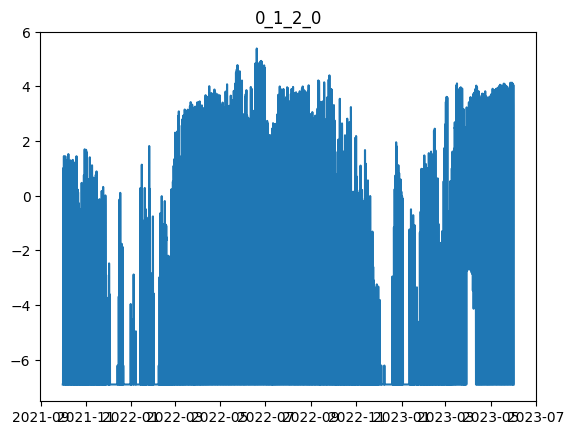

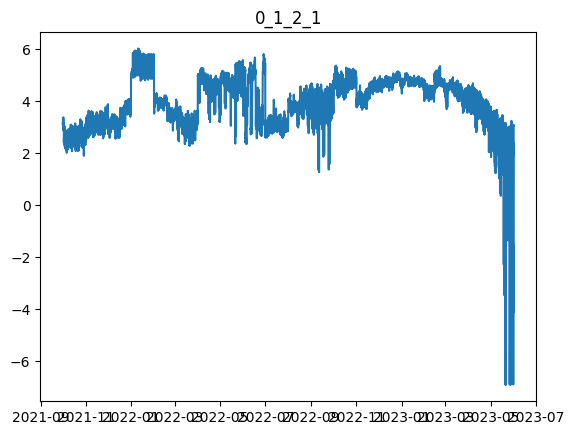

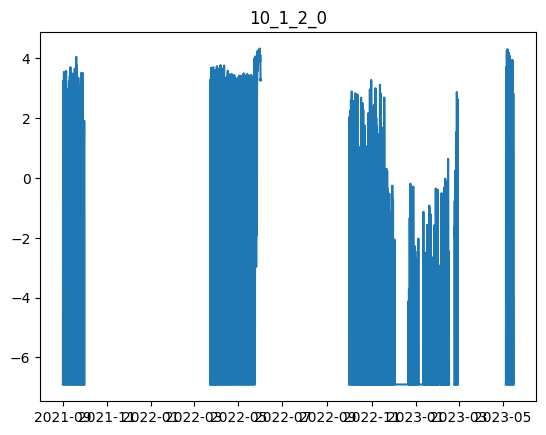

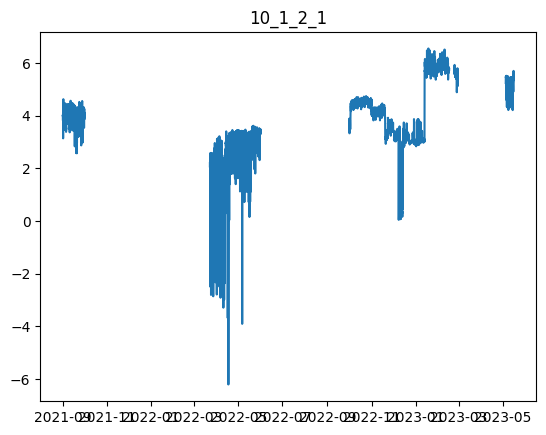

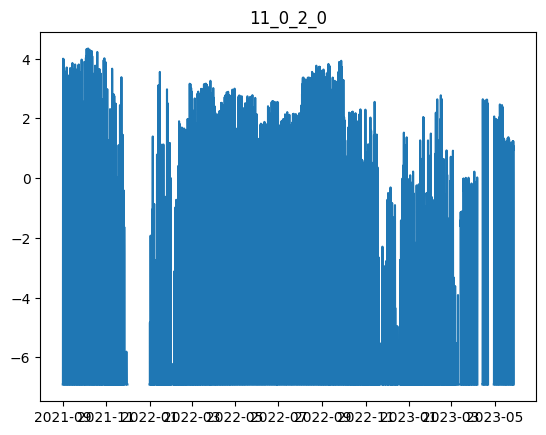

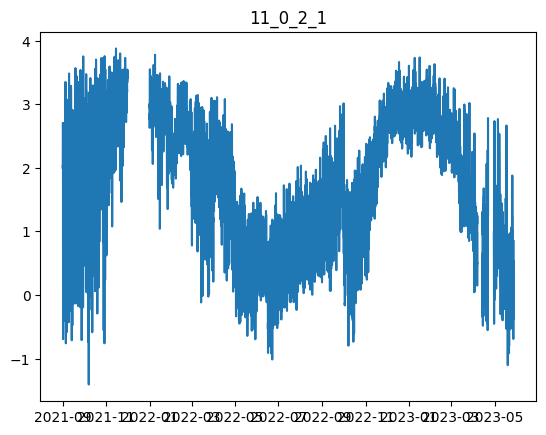

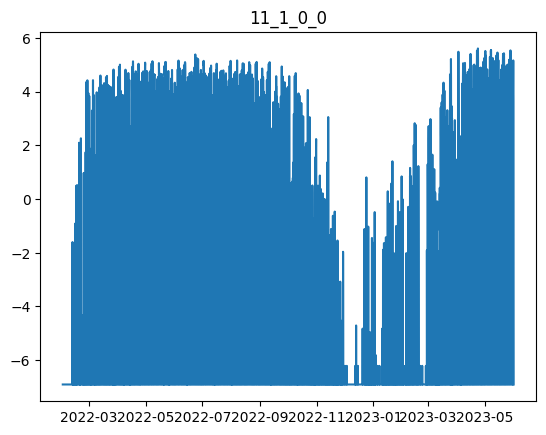

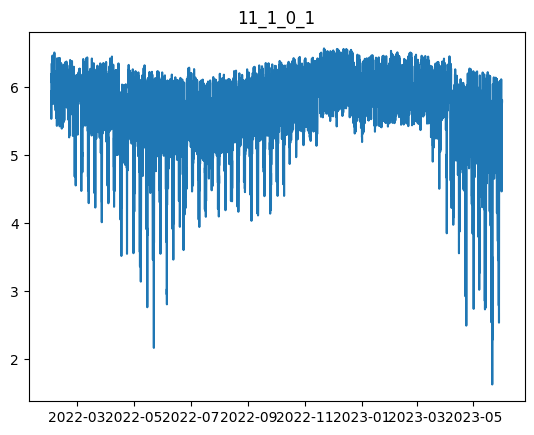

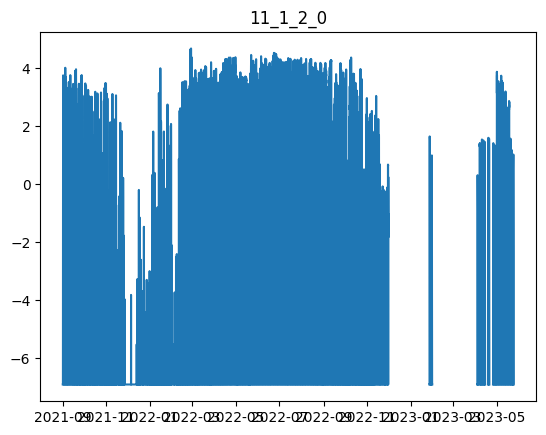

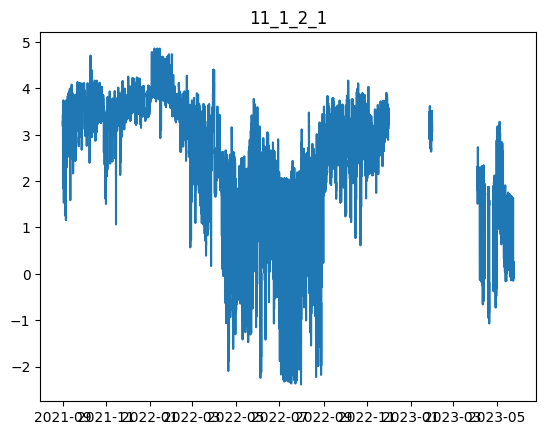

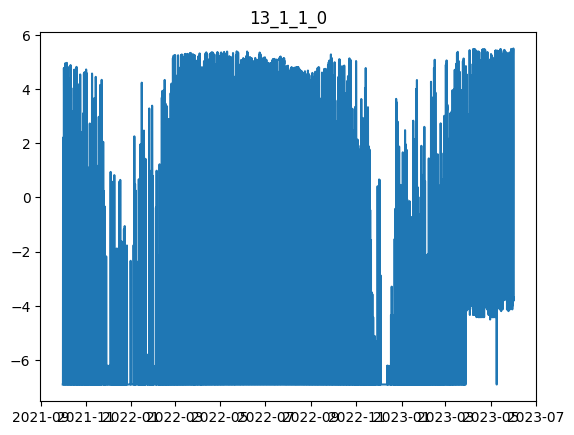

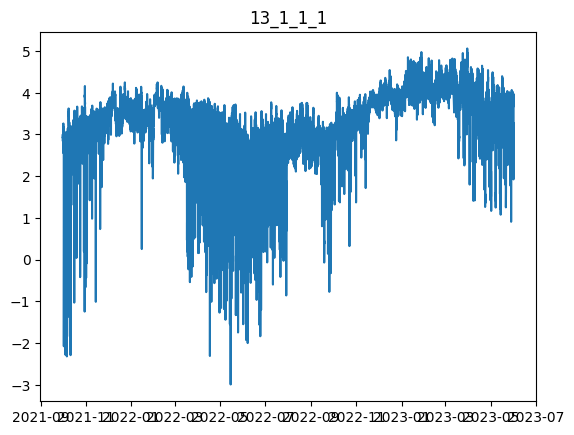

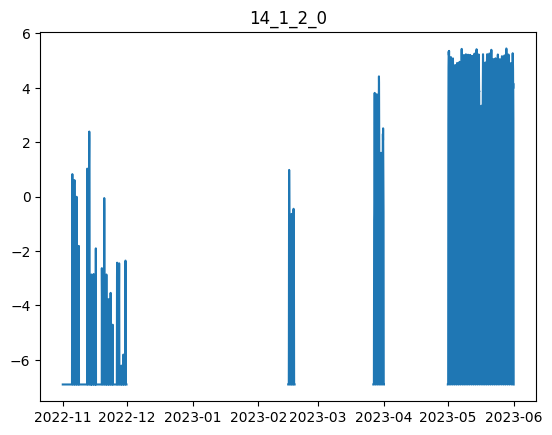

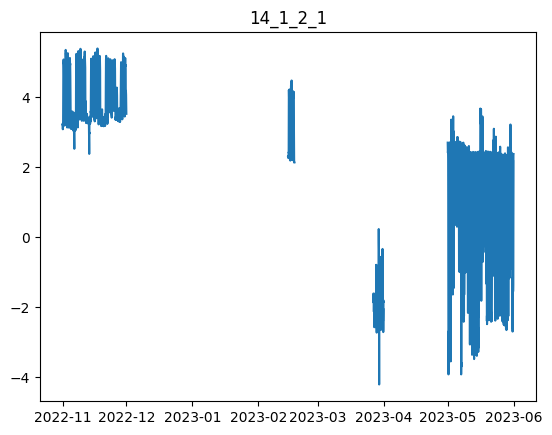

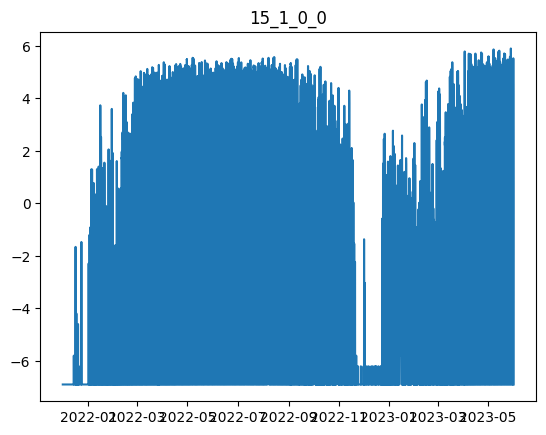

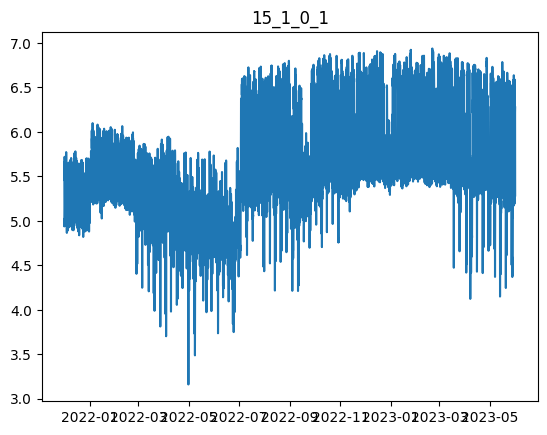

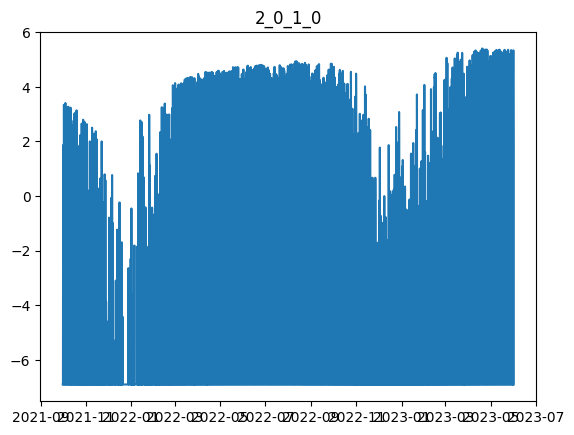

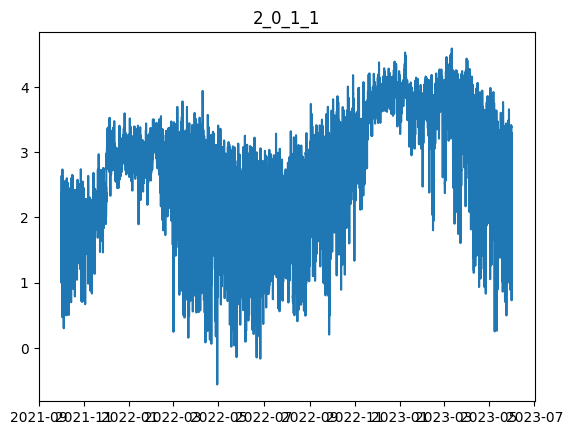

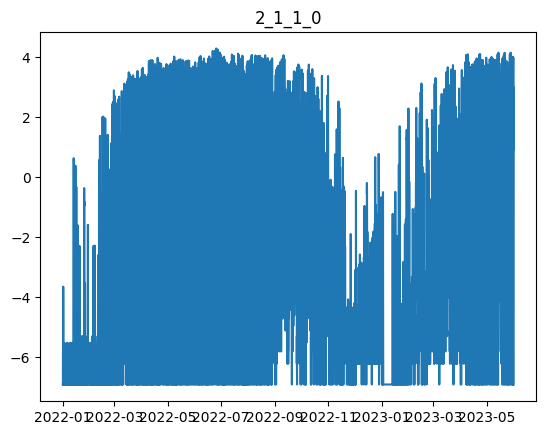

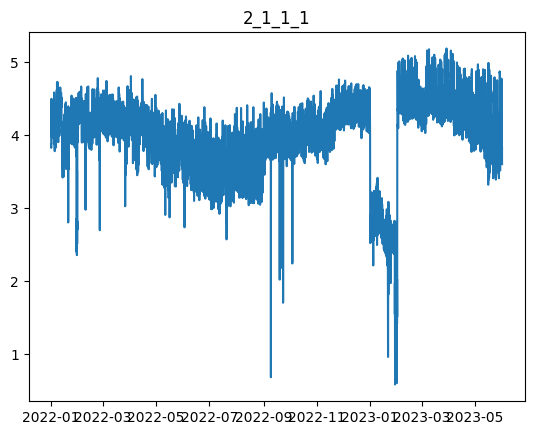

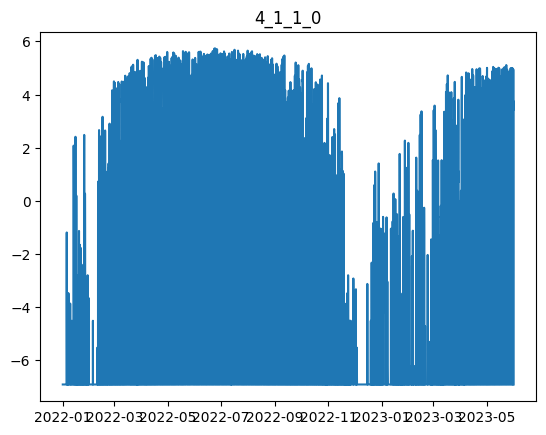

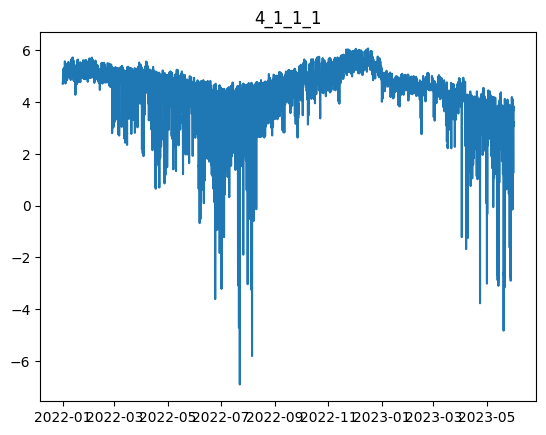

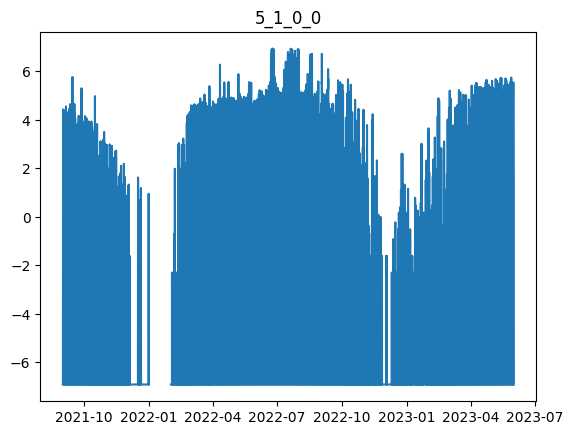

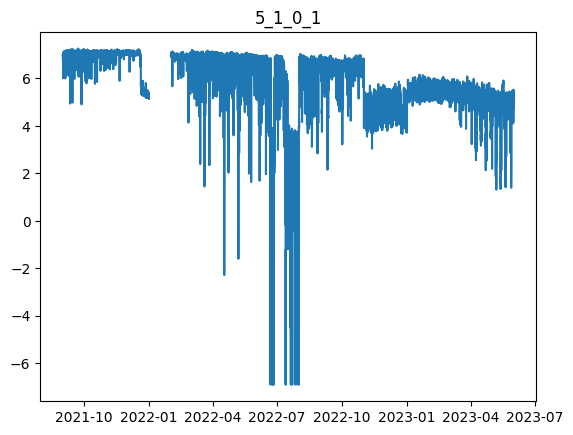

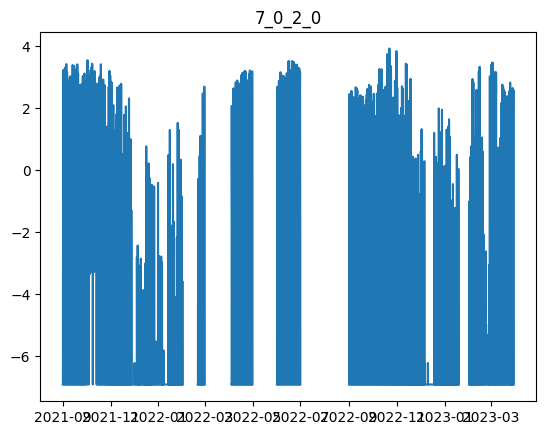

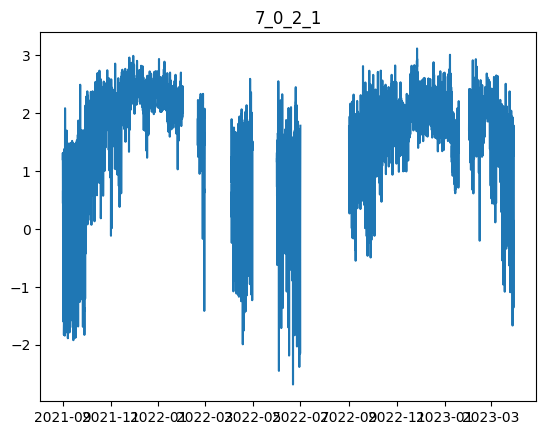

In [7]:
sparse_cat = list(sparse_df_dict.keys())
    
# Plot time series in a separate figure for each category and title the figure with the category name
for i, cat in enumerate(sparse_cat):
    plt.figure(i)
    plt.title(cat)
    plt.plot(sparse_df_dict[cat]["datetime"], sparse_df_dict[cat]["log_target"])
    plt.show()

In [13]:
# Interpolate missing values
# Strategy: linear interpolation of the log(target) values using the nearest weekly data available
# Rationale: the data has a clear weekly pattern, so it makes sense to look 7 days ahead and behind for the nearest data, rather than next day or previous day
def impute_target_values(df):
    for i in range(168):
        start_time = all_times[0] + pd.Timedelta(hours=i)
        weekly_range = pd.date_range(start=start_time, end=all_times[-1], freq='w')
        mini_df = df[df["datetime"].isin(weekly_range)]
        mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
        df.update(mini_df["log_target"])

    # Fill in the remaining NANs by interpolating linearly from the nearest data
    df["log_target"] = df["log_target"].interpolate(method='linear', limit_direction='both', limit=168)
    df["target"] = np.exp(df["log_target"]) - 0.001
    return df

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

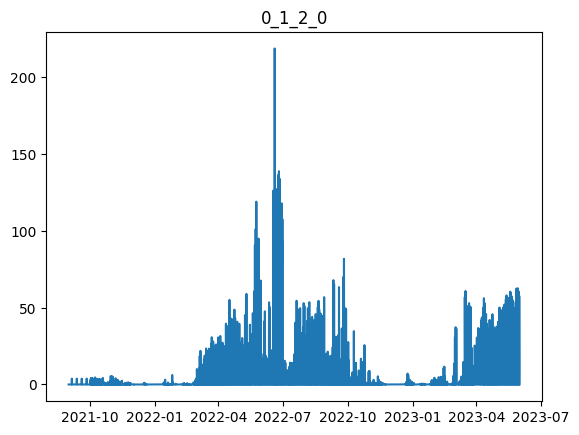

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

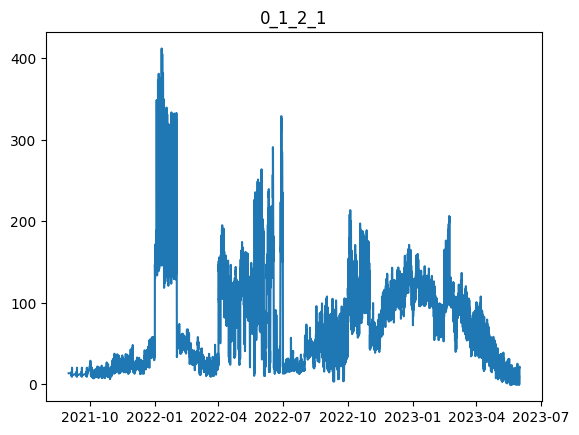

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

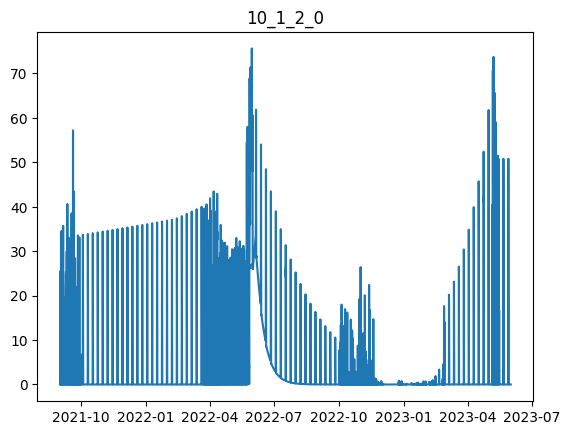

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

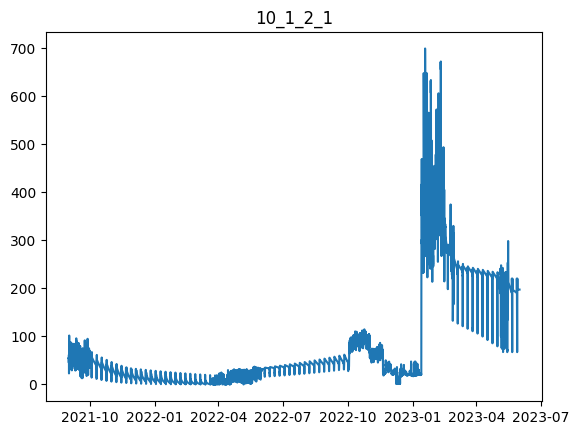

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

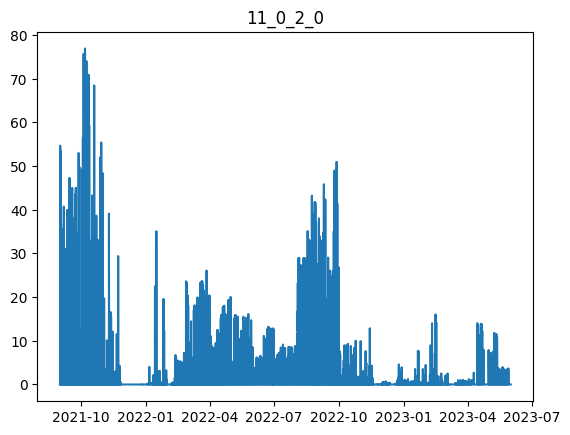

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

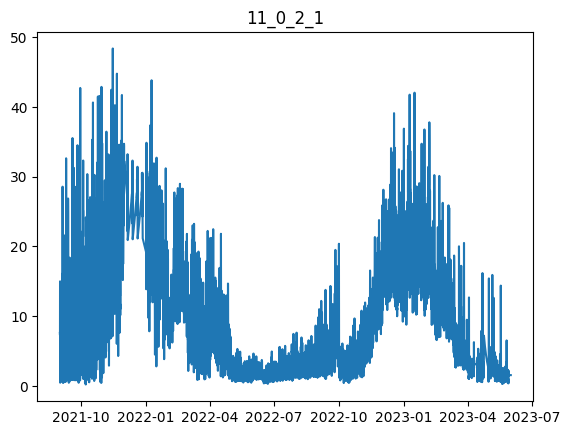

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

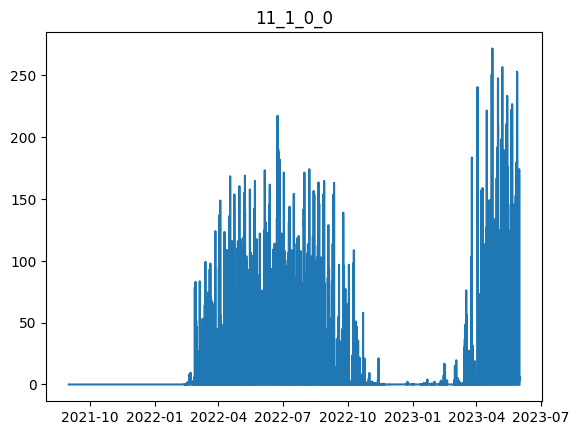

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

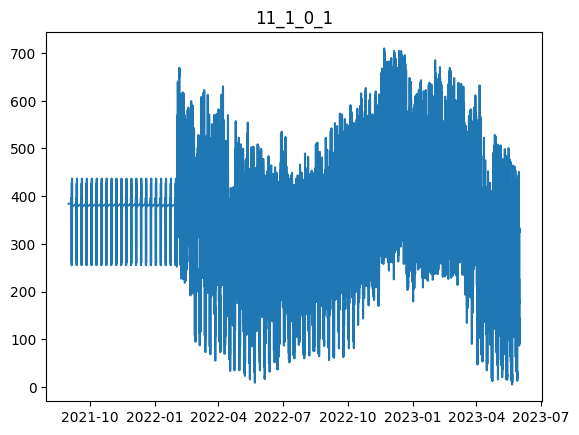

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

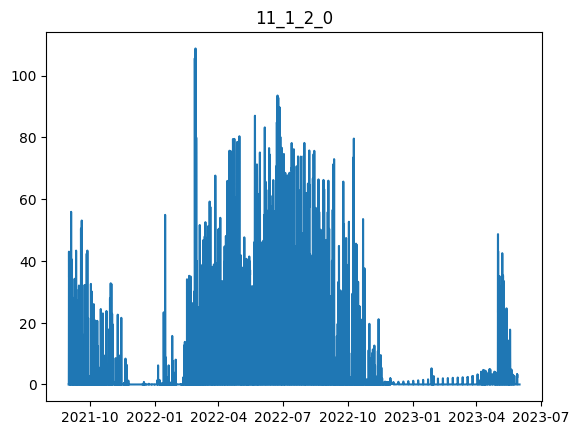

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

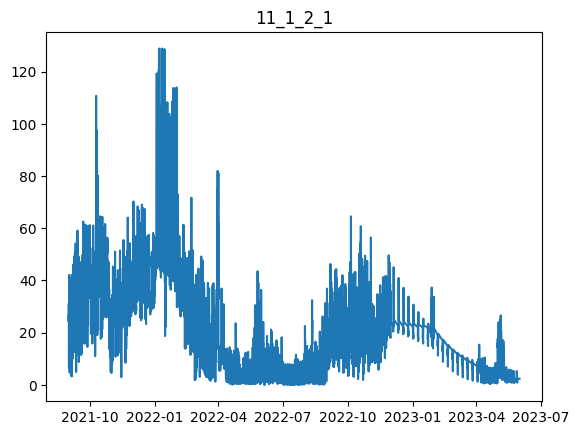

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

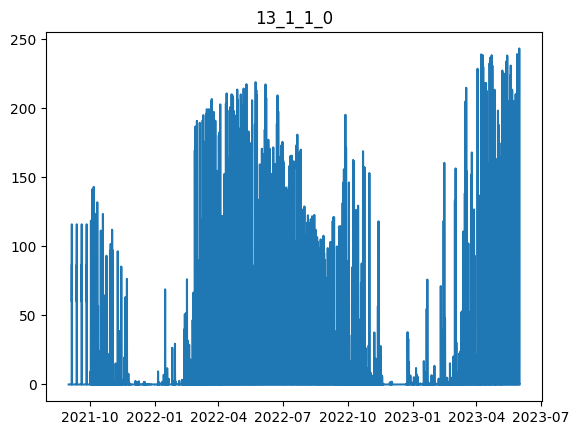

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

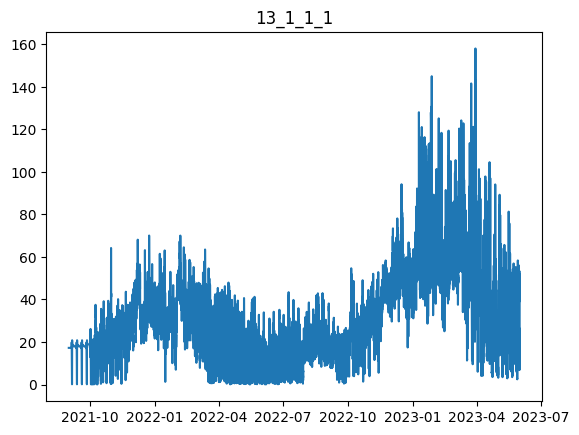

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

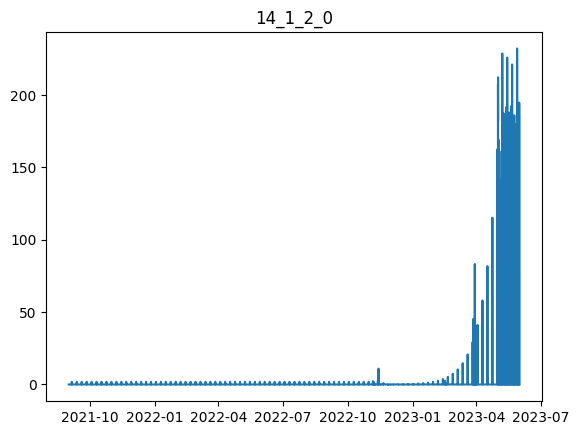

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

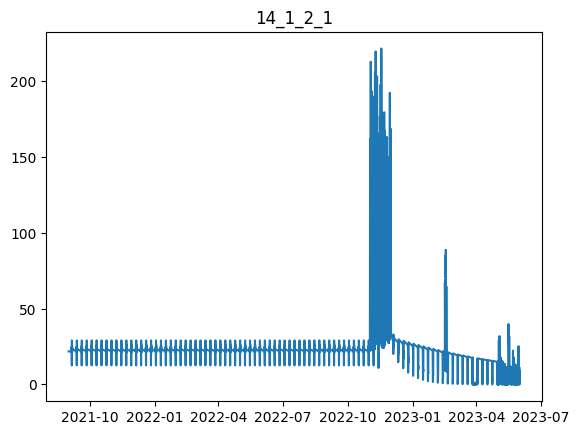

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

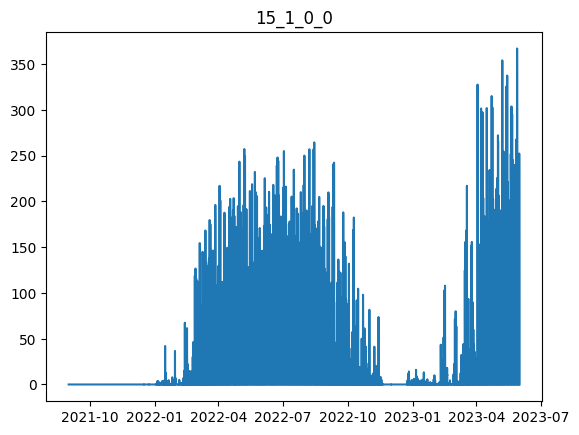

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

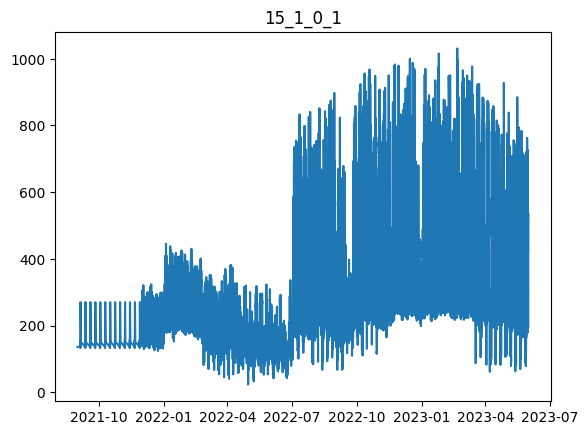

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

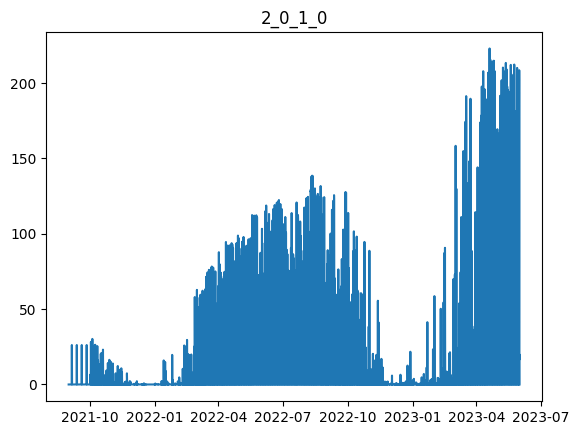

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

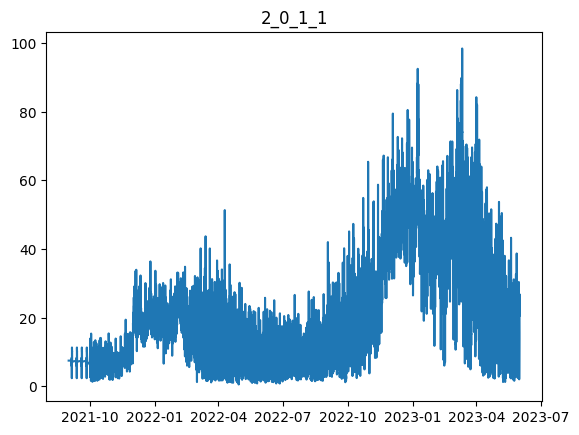

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

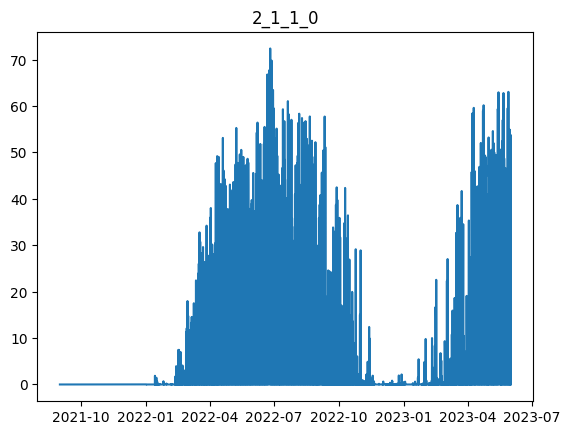

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

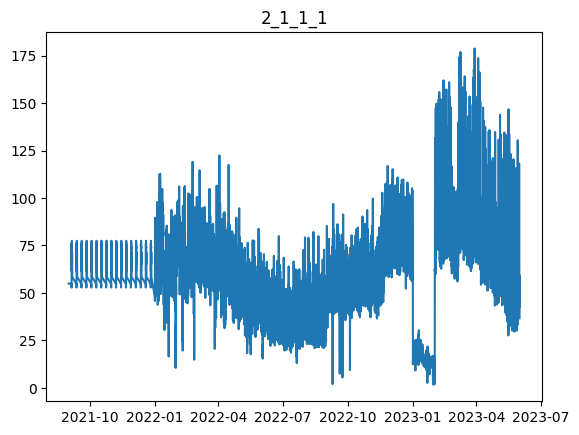

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

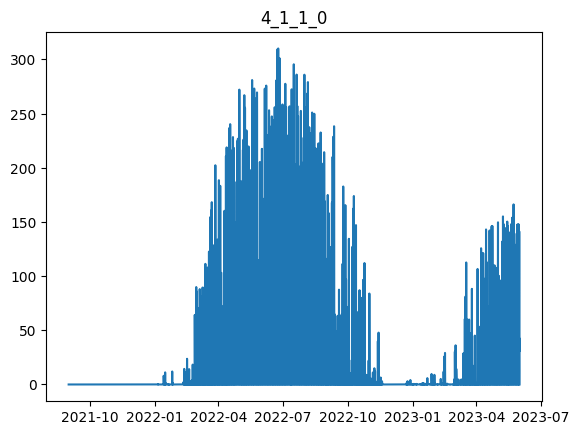

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

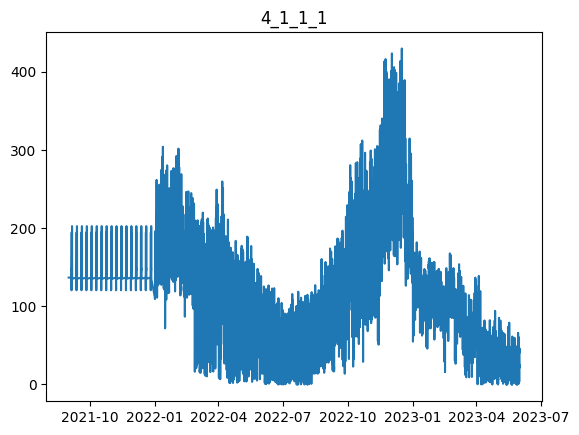

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

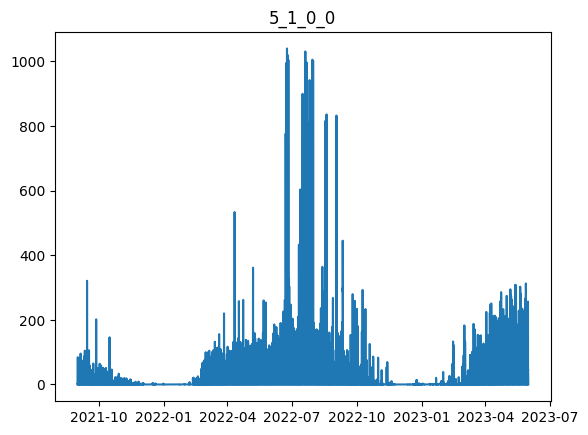

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

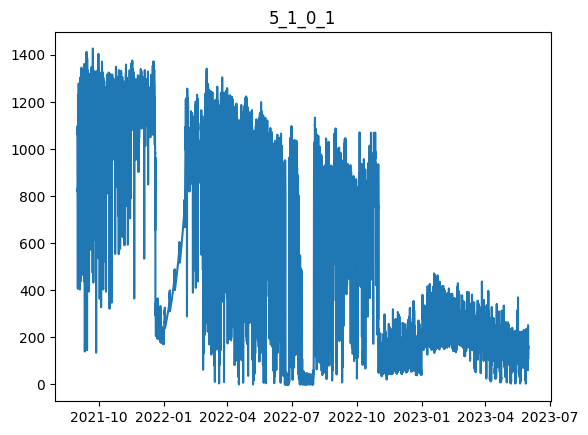

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

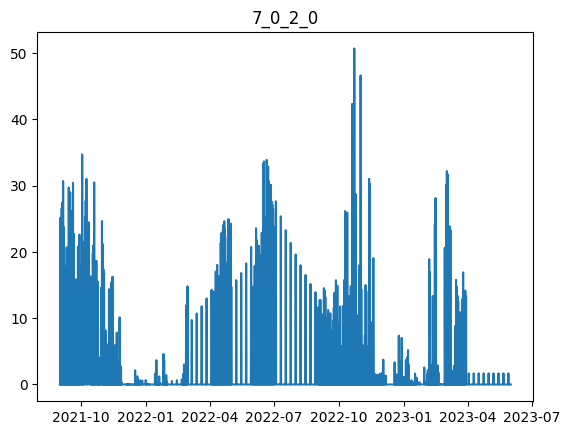

/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["log_target"] = mini_df["log_target"].interpolate(method='linear', limit_direction='both')
/tmp/ipykernel_43140/1137614186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

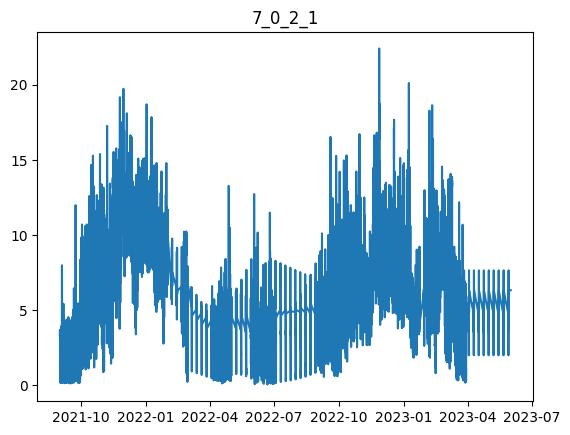

In [15]:
for i, cat in enumerate(sparse_cat):
    sparse_df_dict[cat] = impute_target_values(sparse_df_dict[cat])
    plt.figure(i)
    plt.title(cat)
    plt.plot(sparse_df_dict[cat]["datetime"], sparse_df_dict[cat]["target"])
    plt.show()